In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load preprocessed data
artifacts_dir = '../artifacts'

print("Loading preprocessed data...")
data = joblib.load(os.path.join(artifacts_dir, 'preprocessed_data.joblib'))
vectorizer = joblib.load(os.path.join(artifacts_dir, 'tfidf_vectorizer.joblib'))

# Extract data components
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
feature_names = data['feature_names']
class_names = data['class_names']

print(f"Data loaded successfully!")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of classes: {len(class_names)}")
print(f"Classes: {class_names}")

Loading preprocessed data...
Data loaded successfully!
Training set: (1724, 5000)
Validation set: (370, 5000)
Test set: (370, 5000)
Number of classes: 13
Classes: ['Cardiovascular / Pulmonary', 'ENT - Otolaryngology', 'Gastroenterology', 'Hematology - Oncology', 'Nephrology', 'Neurology', 'Neurosurgery', 'Obstetrics / Gynecology', 'Ophthalmology', 'Orthopedic', 'Pediatrics - Neonatal', 'Psychiatry / Psychology', 'Radiology']


In [3]:
# Initialize Softmax Regression model
print("Initializing Softmax Regression (Multinomial Logistic Regression)...")

# Configure the model for multi-class classification
softmax_model = LogisticRegression(
    multi_class='multinomial',  # Use multinomial (softmax) approach
    solver='lbfgs',            # Limited-memory BFGS solver (good for small datasets)
    max_iter=1000,             # Increase iterations for convergence
    random_state=42,           # For reproducibility
    class_weight='balanced'    # Handle class imbalance
)

print("Model Configuration:")
print(f"- Multi-class strategy: {softmax_model.multi_class}")
print(f"- Solver: {softmax_model.solver}")
print(f"- Class weight: {softmax_model.class_weight}")
print(f"- Max iterations: {softmax_model.max_iter}")

Initializing Softmax Regression (Multinomial Logistic Regression)...
Model Configuration:
- Multi-class strategy: multinomial
- Solver: lbfgs
- Class weight: balanced
- Max iterations: 1000


In [4]:
# Train the baseline model
print("Training baseline Softmax Regression model...")

softmax_model.fit(X_train, y_train)

print("Model training completed!")
print(f"Number of classes learned: {len(softmax_model.classes_)}")
print(f"Feature coefficient shape: {softmax_model.coef_.shape}")
print(f"Classes: {softmax_model.classes_}")

Training baseline Softmax Regression model...
Model training completed!
Number of classes learned: 13
Feature coefficient shape: (13, 5000)
Classes: ['Cardiovascular / Pulmonary' 'ENT - Otolaryngology' 'Gastroenterology'
 'Hematology - Oncology' 'Nephrology' 'Neurology' 'Neurosurgery'
 'Obstetrics / Gynecology' 'Ophthalmology' 'Orthopedic'
 'Pediatrics - Neonatal' 'Psychiatry / Psychology' 'Radiology']


Performing 5-fold stratified cross-validation...
Cross-Validation Results:
Accuracy:  0.7848 ± 0.0176
Precision: 0.7269 ± 0.0208
Recall:    0.7857 ± 0.0316
F1-Score:  0.7425 ± 0.0249


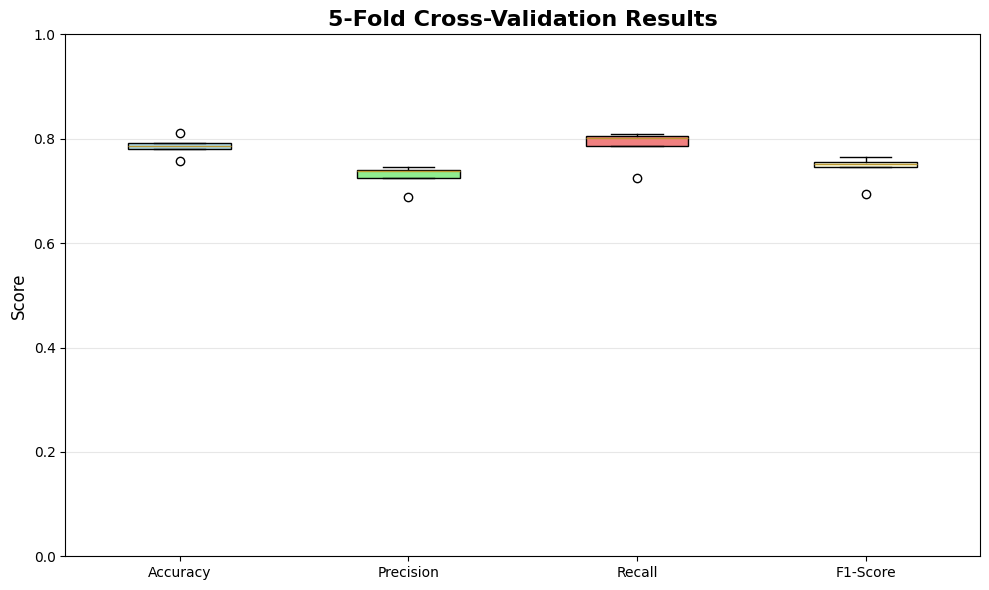

In [5]:
# Perform stratified cross-validation
print("Performing 5-fold stratified cross-validation...")

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate multiple metrics through cross-validation
cv_accuracy = cross_val_score(softmax_model, X_train, y_train, 
                             cv=cv_strategy, scoring='accuracy')
cv_precision = cross_val_score(softmax_model, X_train, y_train, 
                              cv=cv_strategy, scoring='precision_macro')
cv_recall = cross_val_score(softmax_model, X_train, y_train, 
                           cv=cv_strategy, scoring='recall_macro')
cv_f1 = cross_val_score(softmax_model, X_train, y_train, 
                       cv=cv_strategy, scoring='f1_macro')

print("Cross-Validation Results:")
print(f"Accuracy:  {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
print(f"Precision: {cv_precision.mean():.4f} ± {cv_precision.std():.4f}")
print(f"Recall:    {cv_recall.mean():.4f} ± {cv_recall.std():.4f}")
print(f"F1-Score:  {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")

# Visualize cross-validation results
cv_results = {
    'Accuracy': cv_accuracy,
    'Precision': cv_precision,
    'Recall': cv_recall,
    'F1-Score': cv_f1
}

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
box_data = [cv_results[metric] for metric in cv_results.keys()]
box_plot = ax.boxplot(box_data, labels=cv_results.keys(), patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title('5-Fold Cross-Validation Results', fontsize=16, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [7]:
# Define hyperparameter grid
print("Starting hyperparameter tuning with GridSearchCV...")

param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'solver': ['lbfgs', 'liblinear'],  # Different solvers
    'class_weight': ['balanced', None]  # Class weighting strategies
}

# Create base model
base_model = LogisticRegression(
    multi_class='multinomial',
    max_iter=1000,
    random_state=42
)

# Perform grid search
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=cv_strategy,
    scoring='f1_macro',  # Use F1-macro as it handles class imbalance well
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nHyperparameter tuning completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Hyperparameter tuning completed!
Best parameters: {'C': 10.0, 'class_weight': 'balanced', 'solver': 'lbfgs'}
Best cross-validation F1-score: 0.7469
